In [1]:
# General imports
import os
import tables as tb
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path

# Brian with units and wrapped numpy
import brian2 as br
from brian2 import um, mm, cm, meter
from brian2 import mV, ms, second, ohm, siemens, msiemens, farad, ufarad
from brian2 import np

# Custom scripts
import pyoelectricity as pel

# Load files

In [11]:
data_path = Path('simulation', 'purkinje')

In [9]:
filenames = [
    '1um_2k-ohh.h5',
    '1um_2k-otm.h5',
    '1um_2k-ortm-0.25.h5',
    '1um_2k-ortm-0.50.h5',
    '1um_2k-ortm-1.00.h5',
    '1um_2k--hh.h5',
    '1um_2k--tm.h5',
    '1um_2k--rtm-0.50.h5']

results = {}
for f in filenames:
    print('Loading', f)
    results[f] = pel.get_result(Path(data_path, f))

Loading 1um_2k-ohh.h5
Loading 1um_2k-otm.h5
Loading 1um_2k-ortm-0.25.h5
Loading 1um_2k-ortm-0.50.h5
Loading 1um_2k-ortm-1.00.h5
Loading 1um_2k--hh.h5
Loading 1um_2k--tm.h5
Loading 1um_2k--rtm-0.50.h5


# Morphology & source AP

In [4]:
def plot_morpho(result):
    fig, ax = plt.subplots(1, 1, figsize=(16,2))
    ax.axis('equal')

    source_patchs = [plt.Circle((x, y), d/2.0) for x, y, d in zip(
        result['source_x']/um, result['source_y']/um, result['source_d']/um)]
    ax.add_collection(mpl.collections.PatchCollection(source_patchs, color='red', label="Source"))    

    target_patchs = [plt.Circle((x, y), d/2.0) for x, y, d in zip(
        result['target_x']/um, result['target_y']/um, result['target_d']/um)]
    u = mpl.collections.PatchCollection(target_patchs, color='green', label='Target')
    ax.add_collection(u)    

    ax.set_ylim(-3, 3)
    ax.set_xlim(1000-30, 1000+30)
    ax.set_xlabel('x/um')
    ax.set_ylabel('y/um')
    legend_elements = [mpl.lines.Line2D([0], [0], marker='o', color='w',
                                        markerfacecolor='red', markersize=10, label='Source'),
                       mpl.lines.Line2D([0], [0], marker='o', color='w',
                                        markerfacecolor='green', markersize=10, label='Target')]
    ax.legend(handles=legend_elements, ncol=2)

def check_morpho(result, lbl=''):
    print(f'{lbl:16s} | {"Source max":16s}|{"Target min":16s}|{"Target max":16s}')
    print((16*5+4)*'-')
    def print_lims(quant):
        print(f'{quant:4s} {str(result["source_"+quant].shape):>12s} | '
              +f'{result["source_"+quant].min().in_best_unit(3):>14s} | '
              +f'{result["source_"+quant].max().in_best_unit(3):>14s} | '
              +f'{result["target_"+quant].min().in_best_unit(3):>14s} | '
              +f'{result["target_"+quant].max().in_best_unit(3):>14s}'
             )
    print_lims('x')
    print_lims('y')
    print_lims('d')
    print_lims('v')
    print_lims('t')
    
    plot_morpho(result)
    plt.show()

No bouton        | Source max      |Target min      |Target max      
------------------------------------------------------------------------------------
x         (2000,) |        250. nm |          1. mm |         0.5 mm |         1.5 mm
y         (2000,) |           0. m |           0. m |          1. um |          1. um
d         (2000,) |          1. um |          1. um |          1. um |          1. um
v    (2000, 80100) |     -11.205 mV |        0.446 V |      -0.416 mV |      275.81 uV
t        (80100,) |           0. s |        8.01 ms |           0. s |        8.01 ms


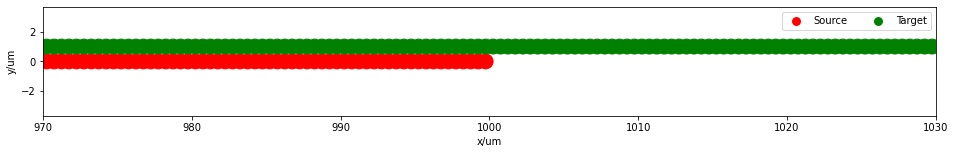

Bouton           | Source max      |Target min      |Target max      
------------------------------------------------------------------------------------
x         (2000,) |        250. nm |          1. mm |         0.5 mm |         1.5 mm
y         (2000,) |           0. m |           0. m |          1. um |          1. um
d         (2000,) |          1. um |          2. um |          1. um |          1. um
v    (2000, 80100) |     -11.205 mV |        0.446 V |      -0.417 mV |      275.81 uV
t        (80100,) |           0. s |        8.01 ms |           0. s |        8.01 ms


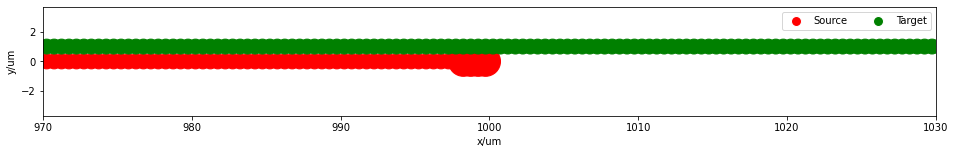

In [5]:
check_morpho(results['1um_2k--hh.h5'], 'No bouton')
check_morpho(results['1um_2k-ohh.h5'], 'Bouton')

Simulation:  0.34m/s,  0.198mm


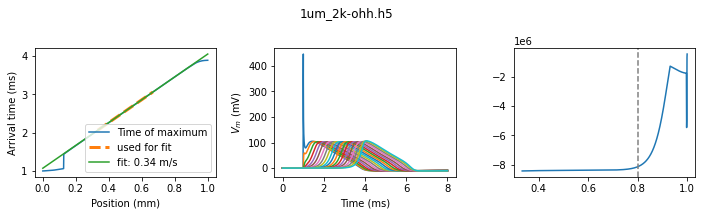

In [7]:
for f in results:
    result = results[f]
    # Calculate v and lambda_star from simulation
    v_p, lambda_star = pel.get_velocity(M=None,
                           make_plots=True,
                           is_collision=False,
                           time_m=result['source_t'],
                           x_m=result['source_x'],
                           v_m=result['source_v'],
                           figsize=(10,3)
                          )
    plt.suptitle(f);
    plt.tight_layout()
    break

# Impact Overview (SI Figure)

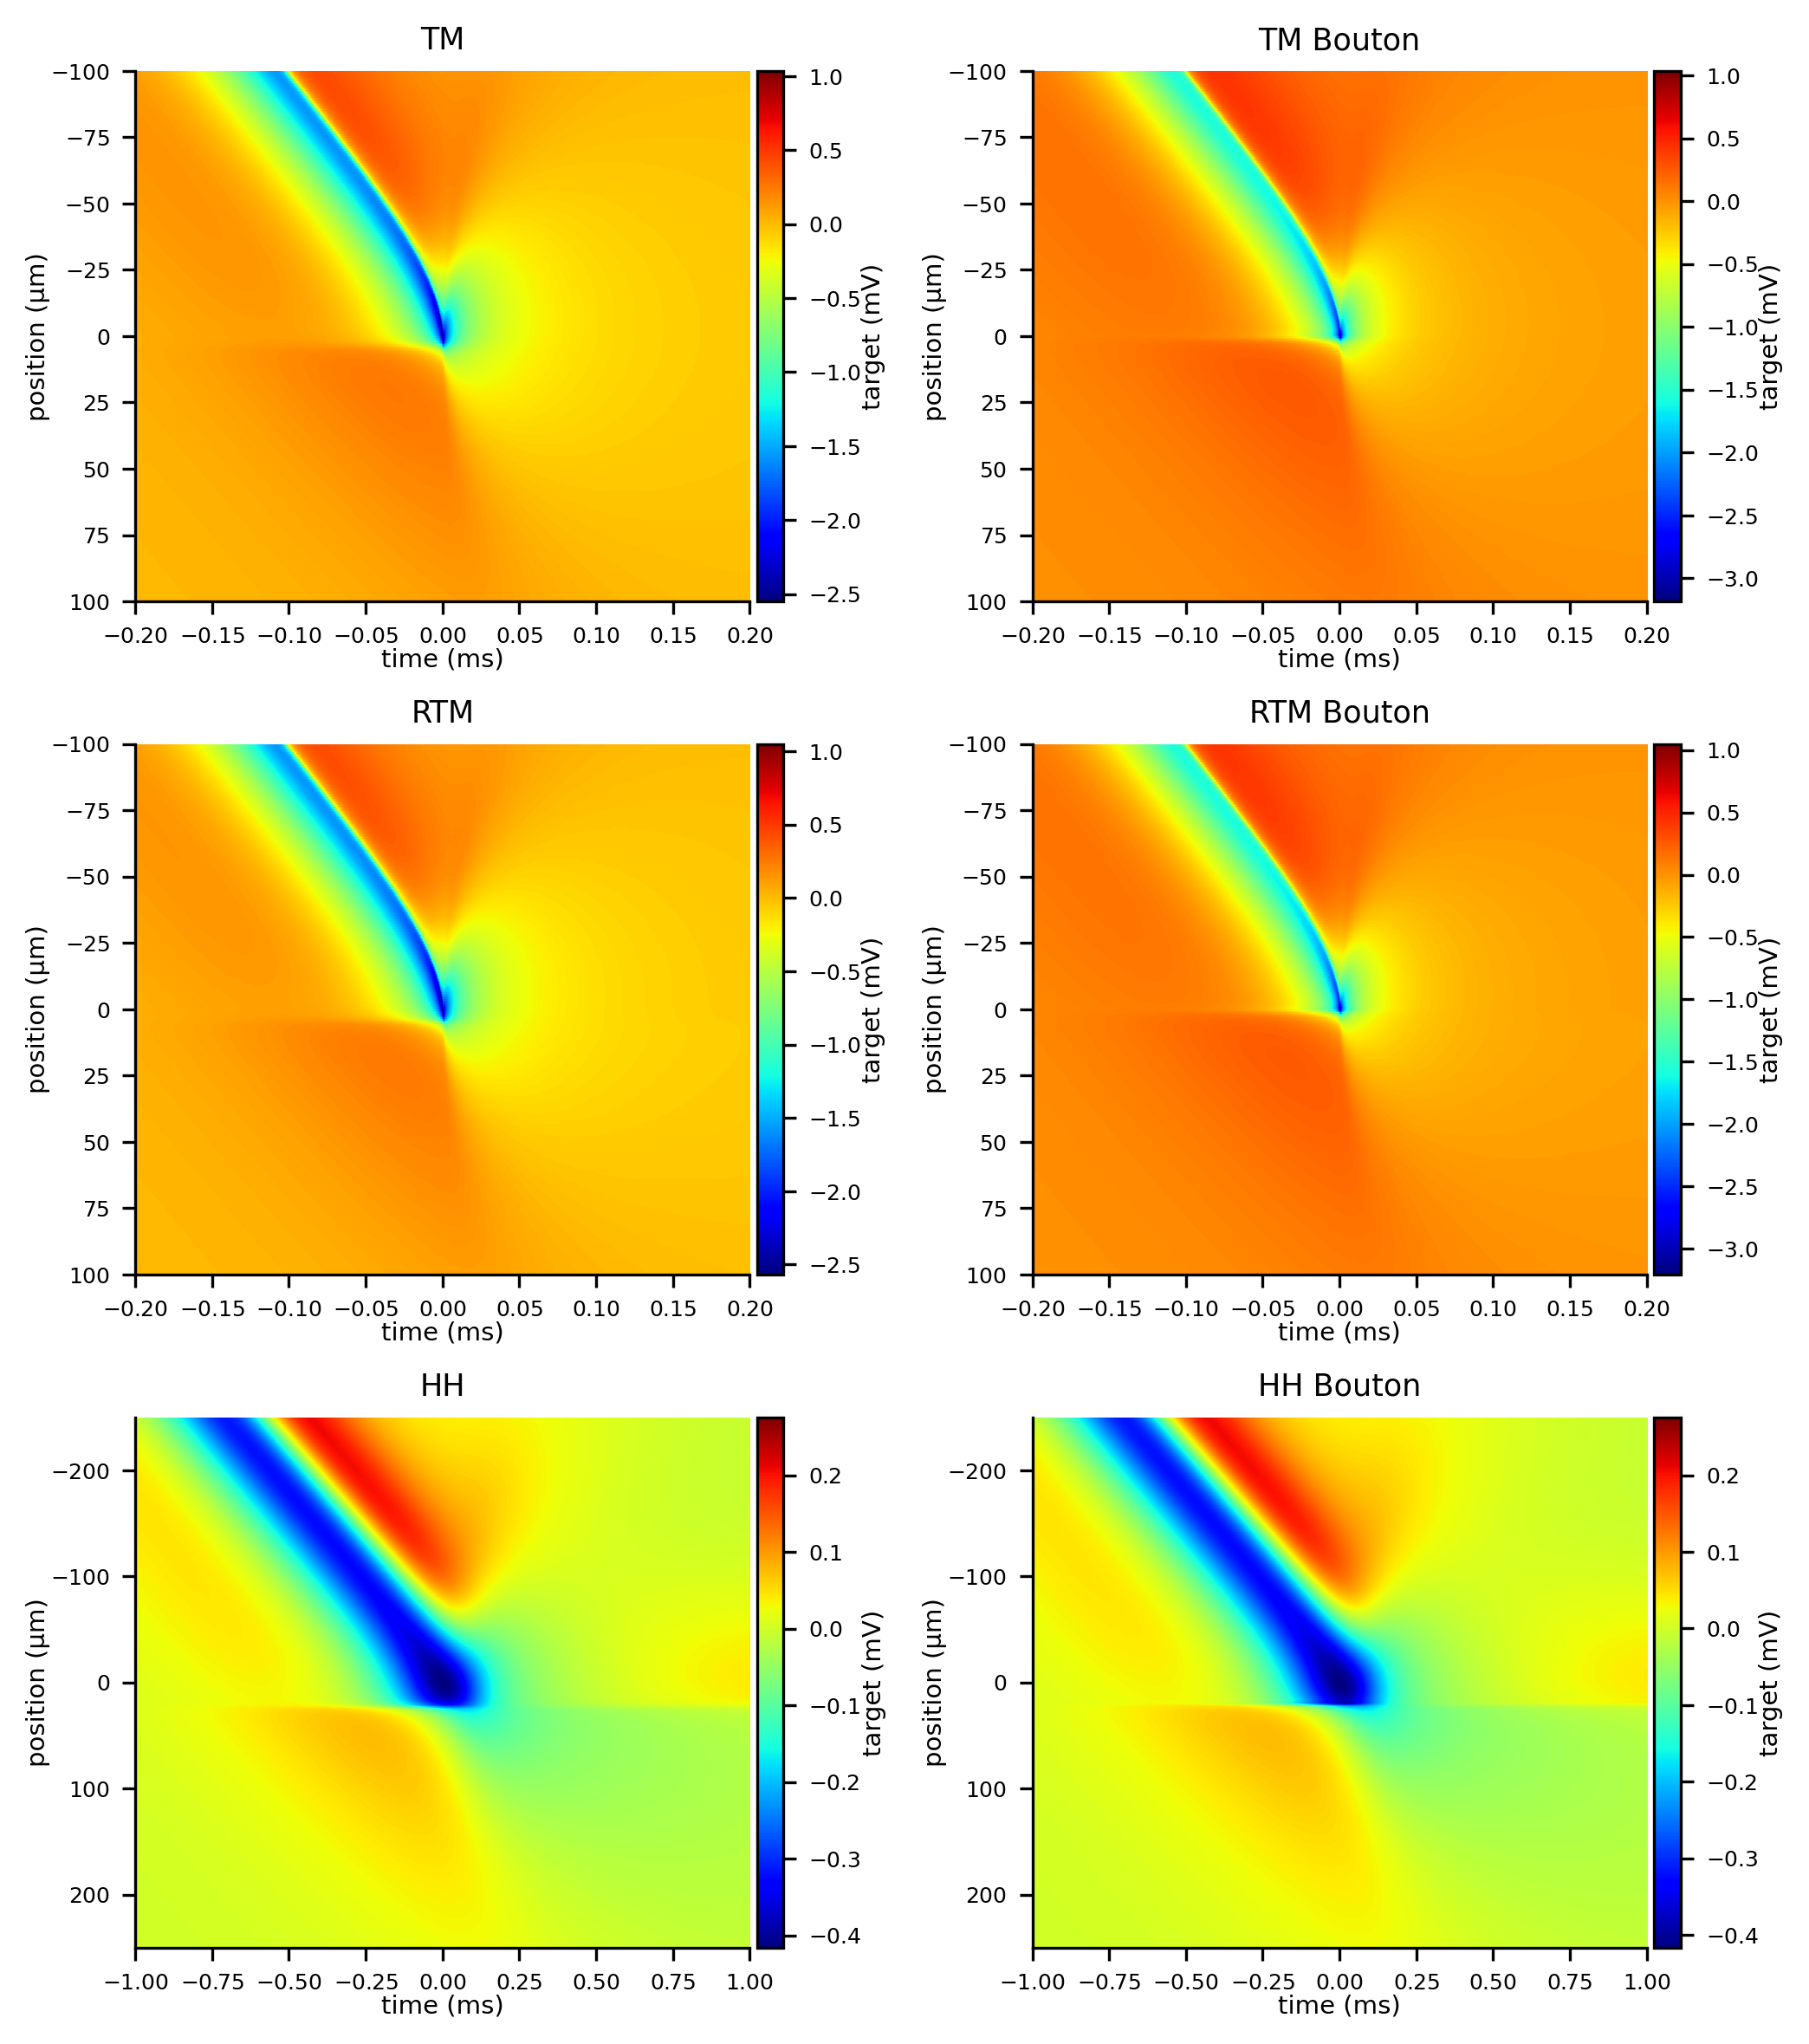

In [8]:
def putimg(title, result, ax, dt=0.6, dy=100, clbl='target (mV)', **kwargs):
    ax.set_title(title)
    v = result['target_v']/br.mV
    ix, it = np.unravel_index(np.argmin(v, axis=None), v.shape)
    t0 = result['target_t'][it]/br.ms
    x0 = result['target_x'][ix]/br.um
    im0 = ax.imshow(v,
                    extent=[(result['target_t'][0])/br.ms -t0,
                            (result['target_t'][-1])/br.ms -t0,
                            (result['target_x'][-1])/br.um -x0,
                            (result['target_x'][0])/br.um -x0,
                           ],
                    aspect='auto',
                    interpolation='none',
                    #vmin=-10,
                    cmap='jet',
                    **kwargs
                   )
    
    #ax.axhline(result['target_x'][ix]/br.um - x0, ls = '--')
    #ax.axvline(result['target_t'][it]/br.ms - t0, ls = '--')
    ax.set_xlim(-dt, +dt)
    ax.set_ylim(dy, -dy)
    ax.set_ylabel("position (µm)")
    ax.set_xlabel("time (ms)")
    
    fig.colorbar(im0, ax=ax, pad=0.01, label=clbl)
    

with plt.style.context('plot_style.txt'):
    cm = 1/2.54 # 11.4 or 17.8
    fig, axs = plt.subplots(3,2, figsize=(17.8*cm, 20*cm))#, sharey=True, sharex='col')
    
    putimg('TM', results['1um_2k--tm.h5'],
           axs[0,0], dt=0.2)# label=r'$1.0$')
    putimg('RTM', results['1um_2k--rtm-0.50.h5'],
           axs[1,0], dt=0.2)# label=r'$1.0$')
    putimg('HH', results['1um_2k--hh.h5'],
           axs[2,0], dt=1, dy=250)# label=r'$1.0$')
    putimg('TM Bouton', results['1um_2k-otm.h5'],
           axs[0,1], dt=0.2)# label=r'$1.0$')
    putimg('RTM Bouton', results['1um_2k-ortm-0.50.h5'],
           axs[1,1], dt=0.2)# label=r'$1.0$')
    putimg('HH Bouton', results['1um_2k-ohh.h5'], 
           axs[2,1], dt=1, dy=250)# label=r'$1.0$')

    plt.tight_layout()
    plt.savefig("SI-purkinje.pdf")
    plt.show()

# Figure 4

2k-o
HH        : prop_peak = -0.0004174509634238156
$0.25$ ms : prop_peak = -0.0011426464517185894
$0.5$ ms  : prop_peak = -0.0011261651026913473
$1$ ms    : prop_peak = -0.0011234181030828048
TM        : prop_peak = -0.001114279014762098


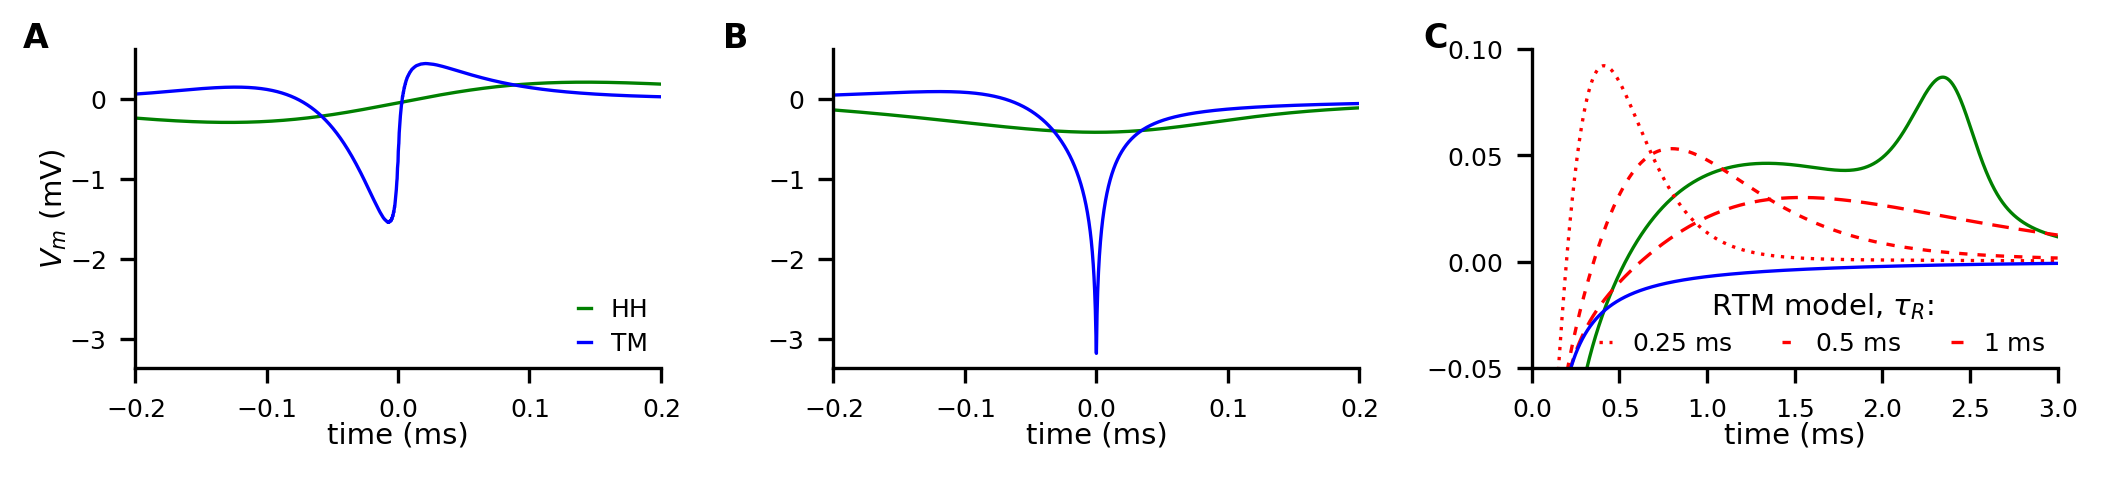

In [10]:
# Create figure
case = '2k-o'

with plt.style.context('plot_style.txt'):
    cm = 1/2.54 # 11.4 or 17.8
    fig, axs = plt.subplots(1,3, sharey=False, figsize=(17.8*cm,4*cm))#, gridspec_kw={'width_ratios':(2,3)})

    def plt_purkinje(result_file, **kwargs):
        result = results[result_file]#pel.get_result(Path(data_path, result_file), downsampling_factor=1)

        vext_max = result['v_ext_v'].min(1)
        prop_peak = vext_max[0]#len(vext_max)//4]
        # print(f'{kwargs["label"]:10s}: prop_peak = {prop_peak}')
        scaling_f = -1.1*mV/prop_peak

        source_n = result['source_v'].shape[0]
        ix_min = result['target_v'].min(1).argmin()

        t, v = result['target_t'], result['target_v']#*scaling_f

        # Plot target impact by propagaging AP
        v_propagating = v[ix_min//3,:]
        t_0_propagating = t[v_propagating.argmin()]
        t_0_propagating = t[np.diff(v_propagating).argmax()]
        # Plot target impact by annihilating AP
        v_annihilating = v[ix_min,:]
        t_0_annihilating = t[v_annihilating.argmin()]
        if 'ms' in kwargs['label']:
            axs[2].plot((t-t_0_annihilating)/ms, v_annihilating/mV, **kwargs)
            kwargs.pop('label')
            #axs[1].plot((t-t_0_annihilating)/ms, v_annihilating/mV, **kwargs)
        else:
            axs[0].plot((t-t_0_propagating)/ms, v_propagating/mV, **kwargs)
            axs[1].plot((t-t_0_annihilating)/ms, v_annihilating/mV, **kwargs)
            kwargs.pop('label')
            axs[2].plot((t-t_0_annihilating)/ms, v_annihilating/mV, **kwargs)


    plt_purkinje('1um_'+case+'hh.h5'      , color='green', ls='-', label='HH')
    plt_purkinje('1um_'+case+'rtm-0.25.h5', color='red', ls=(0, (1, 2)), label=r'$0.25$ ms')
    plt_purkinje('1um_'+case+'rtm-0.50.h5', color='red', ls=(0, (2.5, 3)), label=r'$0.5$ ms')
    plt_purkinje('1um_'+case+'rtm-1.00.h5', color='red', ls=(0, (5, 3)), label=r'$1$ ms')
    plt_purkinje('1um_'+case+'tm.h5'      , color='blue', ls='-', label='TM') 

    axs[0].set_xlabel('time (ms)')
    axs[0].set_ylabel('$V_m$ (mV)')
    axs[0].set_xlim(-0.2, 0.2)
    axs[0].legend(loc='lower right')

    axs[1].set_xlabel('time (ms)')
    axs[1].sharey(axs[0])
    axs[1].set_xlim(-0.2, 0.2)

    axs[2].set_xlabel('time (ms)')
    axs[2].set_xlim(0.0,3.0)
    axs[2].set_ylim(-.05, 0.1)
    axs[2].legend(loc='best', title=r'RTM model, $\tau_{R}$:', ncol = 3)

    plt.tight_layout()

    for ax, l in zip(axs, ['A', 'B', 'C']):
        X = ax.get_position().x0 - 0.05
        Y = 0.90
        ax.annotate(l, fontsize=8,family = 'sans-serif', weight = 'bold',
                    xycoords="subfigure fraction", 
                    xy=(X, Y)) 

    fig.savefig('Fig4-ABC.svg', bbox_inches='tight')
    plt.show()